# Wrangling of WeRateDogs Twitter data

## 1. Data gathering

In [359]:
#import libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from matplotlib import pyplot

### 1.1 Twitter archieve data

In [360]:
#read csv file and store in "tweet_data". Take a look on first 5 rows.
tweet_data=pd.read_csv('twitter-archive-enhanced.csv')
tweet_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


### 1.2 Image predictions data

In [361]:
# Use requests library to download tsv file from a website
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)
with open((url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)

In [362]:
# Read in tsv file as a Pandas DataFrame and store in "predictions".
predictions=pd.read_csv('image-predictions.tsv',sep='\t')
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [363]:
#find number of rows, data types and missing values
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### 1.3 Twitter API data

Personal API keys, secrets, and tokens have been replaced with placeholders

In [364]:
# consumer_key = 'XXXX' 
# consumer_secret = 'XXXX'
# access_token = 'XXXX'
# access_secret = 'XXXX'

In [365]:
# Variables created for tweepy query
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [366]:
# Write the querying JSON data into tweet_json.txt
# with open('tweet_json.txt','a',encoding = 'utf8') as f:
#     for tweet_id in tweet_data['tweet_id']:
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode = 'extended') # set mode to extended
#             json.dump(tweet._json, f)
#             f.write('\n')
#         except: 
#             print('tweet_id = %s didn\'t work' % (tweet_id))

In [367]:
# Converting JSON data to dataframe
tweets_list =[]
with open('tweet_json.txt') as file:
    for line in file:    
        tweets_dict = {}
        tweets_json = json.loads(line)        
        try:
            tweets_dict['tweet_id'] = tweets_json['id']
        except:
            tweets_dict['tweet_id'] = 'na'

        tweets_dict['retweet_count'] = tweets_json['retweet_count']
        tweets_dict['favorite_count'] = tweets_json['favorite_count']
        
        tweets_list.append(tweets_dict)

In [368]:
tweets_api = pd.DataFrame(tweets_list)

In [369]:
#find number of rows, data types and missing values
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 3 columns):
favorite_count    2332 non-null int64
retweet_count     2332 non-null int64
tweet_id          2332 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


## 2. Data assessment 

### 2.1 Twitter archieve data

In [370]:
# Display the tweet_data table
tweet_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [371]:
#this displays a summary of the dataframe including the number of non-null values in each column
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [372]:
#this returns a tuple of the dimensions of the dataframe
tweet_data.shape

(2356, 17)

In [373]:
#this returns the datatypes of the columns
tweet_data.dtypes

tweet_id                      int64  
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                     object 
source                        object 
text                          object 
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp    object 
expanded_urls                 object 
rating_numerator              int64  
rating_denominator            int64  
name                          object 
doggo                         object 
floofer                       object 
pupper                        object 
puppo                         object 
dtype: object

In [374]:
#this returns the number of unique values in each column
tweet_data.nunique()

tweet_id                      2356
in_reply_to_status_id         77  
in_reply_to_user_id           31  
timestamp                     2356
source                        4   
text                          2356
retweeted_status_id           181 
retweeted_status_user_id      25  
retweeted_status_timestamp    181 
expanded_urls                 2218
rating_numerator              40  
rating_denominator            18  
name                          957 
doggo                         2   
floofer                       2   
pupper                        2   
puppo                         2   
dtype: int64

In [375]:
#this returns descriptive statistics for each column of data
tweet_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [376]:
#count of duplicates in the dataset
sum(tweet_data.duplicated())

0

In [377]:
#this returns counts of unique values of rating denominator column
tweet_data.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [378]:
# number of tweets which has rating denominator not equal to 10
tweet_data.query('rating_denominator != 10').rating_denominator.count()

23

In [379]:
#this returns counts of unique values of rating numerator
tweet_data.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [380]:
#assess columns where rating numerator is more than 20
pd.set_option('display.max_colwidth',-1)
tweet_data[tweet_data.rating_numerator>20].text

188     @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research                                                                                   
189     @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10                                    
290     @markhoppus 182/10                                                                                                                                                       
313     @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho                                                                       
340     RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…                             
433     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd   

In [381]:
# number of tweets which has rating numerator > 20
tweet_data.query('rating_numerator > 20').rating_numerator.count()

24

In [382]:
#number of null values of exanded urls
tweet_data.expanded_urls.isnull().sum()

59

In [383]:
#this returns counts of unique values of source column
tweet_data.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

During data assessment of tweet_data the following quality and tidiness issues have been found:
<br>

Data quality issues:
* Remove retweets
* Data completeness: columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' should be dropped because they have a lot of missing data and we need only original data for this project.
* Data correctness: 23 tweets have rating denominator not equal to 10. These tweets will be removed.  
* Data correctness: 24 tweets have rating numerator more than 20. These tweets will be removed
* Keep only columns where first prediction p1_dog is True
* Columns shoud be renamed: 'timestamp': 'tweet_timestamp', 'text': 'tweet_text','name': 'dog_name', 'source': 'tweet_source'
* Timestamp should be datetime format
* For source column url should be extracted from html tags.
    
Tideness issues:
* For dog stage we have 4 columns: Doggo, floofer, puppo, pupper. We can create only one column 'dog_stage', where doggo, puppo, pupper are the values.
* Column 'rating numerator' and 'rating denominator' can be merge in one column called 'rating'. Column 'rating_denominator' will be removed because all values are 10. 



### 2.2 Image predictions data

In [384]:
#display image predictions data
predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [385]:
#this displays a summary of the dataframe including the number of non-null values in each column
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [386]:
#this returns a tuple of the dimensions of the dataframe
predictions.shape

(2075, 12)

In [387]:
#this returns the datatypes of the columns
predictions.dtypes

tweet_id    int64  
jpg_url     object 
img_num     int64  
p1          object 
p1_conf     float64
p1_dog      bool   
p2          object 
p2_conf     float64
p2_dog      bool   
p3          object 
p3_conf     float64
p3_dog      bool   
dtype: object

In [388]:
#this returns descriptive statistics for each column of data
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [389]:
#this returns counts of unique values of p1 column
predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
cocker_spaniel               30 
malamute                     30 
French_bulldog               26 
Chesapeake_Bay_retriever     23 
miniature_pinscher           23 
seat_belt                    22 
Staffordshire_bullterrier    20 
German_shepherd              20 
Siberian_husky               20 
web_site                     19 
Cardigan                     19 
teddy                        18 
beagle                       18 
Eskimo_dog                   18 
Maltese_dog                  18 
Shetland_sheepdog            18 
Shih-Tzu                     17 
Rottweiler                   17 
Lakeland_terrier             17 
kuvasz                       16 
Italian_greyhound            16 
          

In [390]:
#find out how many dogs were predicted with first prediction
predictions.p1_dog.value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [391]:
#this returns counts of unique values of p2 column
predictions.p2.value_counts()

Labrador_retriever                104
golden_retriever                  92 
Cardigan                          73 
Chihuahua                         44 
Pomeranian                        42 
Chesapeake_Bay_retriever          41 
French_bulldog                    41 
toy_poodle                        37 
cocker_spaniel                    34 
Siberian_husky                    33 
miniature_poodle                  33 
beagle                            28 
collie                            27 
Eskimo_dog                        27 
Pembroke                          27 
kuvasz                            26 
Italian_greyhound                 22 
Pekinese                          21 
American_Staffordshire_terrier    21 
chow                              20 
Samoyed                           20 
miniature_pinscher                20 
toy_terrier                       20 
malinois                          20 
Boston_bull                       19 
Norwegian_elkhound                19 
Staffordshir

In [392]:
#find out how many dogs were predicted with second prediction
predictions.p2_dog.value_counts()

True     1553
False    522 
Name: p2_dog, dtype: int64

In [393]:
#this returns counts of unique values of p3 column
predictions.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
Staffordshire_bullterrier         32
chow                              32
beagle                            31
cocker_spaniel                    31
Pekinese                          29
toy_poodle                        29
Pomeranian                        29
Pembroke                          27
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
L

In [394]:
#find out how many dogs were predicted with third prediction
predictions.p3_dog.value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

During assessment of image predictions data the following quality issues have been found:
<br>

Data quality issues:
* columns should be renamed: p1 - prediction1, p1_conf- prediction1_CI, p1_dog - prediction1_dog, p2 - prediction2, p2_conf- prediction2_CI, p2_dog - prediction2_dog, p3 - prediction3, p3_conf- prediction3_CI, p3_dog - prediction3_dog. 
* only values where p1_dog is True will be kept


### 2.3 Twitter API data

In [395]:
#display tweets_api table
tweets_api

,favorite_count,retweet_count,tweet_id
0,37419,8129,892420643555336193
1,32149,6024,892177421306343426
2,24247,3987,891815181378084864
3,40723,8292,891689557279858688
4,38954,8983,891327558926688256
5,19565,2984,891087950875897856
6,11432,1977,890971913173991426
7,63090,18087,890729181411237888
8,26920,4093,890609185150312448
9,30861,7071,890240255349198849


In [396]:
#this displays a summary of the dataframe including the number of non-null values in each column
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 3 columns):
favorite_count    2332 non-null int64
retweet_count     2332 non-null int64
tweet_id          2332 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [397]:
#number of duplicated tweets 
tweets_api.tweet_id.duplicated().sum()

0

In [398]:
#this returns a tuple of the dimensions of the dataframe
tweets_api.shape

(2332, 3)

In [399]:
#this returns descriptive statistics for each column of data
tweets_api.describe()

,favorite_count,retweet_count,tweet_id
count,2332.000000,2332.000000,2.332000e+03
mean,7801.642796,2853.753859,7.419645e+17
std,12106.726614,4831.528649,6.821088e+16
min,0.000000,1.000000,6.660209e+17
25%,1351.750000,573.750000,6.783205e+17
50%,3396.500000,1334.000000,7.184574e+17
75%,9570.000000,3331.250000,7.986673e+17
max,161597.000000,82006.000000,8.924206e+17


## 3. Cleaning data

### 3.1 Twitter archieve data

In [400]:
#create a copy of the original data before cleaning
tweet_data_clean=tweet_data.copy()

In [401]:
#display first 5 rows
tweet_data_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


***Define***

Convert timestamp to datetime format.

***Code***

In [402]:
tweet_data_clean.timestamp=pd.to_datetime(tweet_data_clean.timestamp)

***Test***

In [403]:
tweet_data_clean.timestamp.dtype

datetime64[ns, UTC]

***Define***

Remove retweets

***Code***

In [404]:
tweet_data_clean=tweet_data_clean[tweet_data_clean.retweeted_status_id.isnull()]

***Test***

In [405]:
#Confirm that retweet_status_id column contains only 0 values (no retweets)
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns, UTC]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns, UT

***Define***

Drop retweet columns since they have only 0 values

***Code***

In [406]:
tweet_data_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

***Test***

In [407]:
# Confirm retweet columns are gone
list(tweet_data_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

***Define***

Remove in reply to status tweets 

***Code***

In [408]:
tweet_data_clean=tweet_data_clean[tweet_data_clean.in_reply_to_status_id.isnull()]

***Test***

In [409]:
#Confirm that in_reply_to_status_id contains only 0 values (no in replies)
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2097 non-null int64
in_reply_to_status_id    0 non-null float64
in_reply_to_user_id      0 non-null float64
timestamp                2097 non-null datetime64[ns, UTC]
source                   2097 non-null object
text                     2097 non-null object
expanded_urls            2094 non-null object
rating_numerator         2097 non-null int64
rating_denominator       2097 non-null int64
name                     2097 non-null object
doggo                    2097 non-null object
floofer                  2097 non-null object
pupper                   2097 non-null object
puppo                    2097 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(8)
memory usage: 245.7+ KB


***Define***

Drop in reply to status columns

***Code***

In [410]:
tweet_data_clean.drop(['in_reply_to_status_id','in_reply_to_user_id'], axis=1, inplace=True)

***Test***

In [411]:
# Confirm in reply to status id columns are gone
list(tweet_data_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

***Define***

Removing numerator which is higher than 20 because there are only 24 cases where rating numerator >20

***Code***

In [412]:
tweet_data_clean.query('rating_numerator <= 20', inplace=True)

***Test***

In [413]:
#confirm that rating_numerator values<20
tweet_data_clean.rating_numerator.max()

14

***Define***

Removing rating denominator not equal to 10, since almost all values have rating denominator equal to 10

***Code***

In [414]:
tweet_data_clean.query('rating_denominator == 10', inplace=True)

***Test***

In [415]:
#confirm that rating_denominator column has only values equal to 10
tweet_data_clean.rating_denominator.value_counts()

10    2075
Name: rating_denominator, dtype: int64

***Define***

Devide rating_numerator column by 10 and rename the column to 'dog_rating' (which is equal to rating_numerator/rating_denominator')

***Code***

In [416]:
tweet_data_clean.rating_numerator=tweet_data_clean.rating_numerator/10

In [417]:
tweet_data_clean.rename(columns={'rating_numerator':'dog_rating'}, inplace=True)

***Test***

In [418]:
#confirm that we have a dog_rating column
list(tweet_data_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'dog_rating',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [419]:
#check that dog_rating values are devided by 10
tweet_data_clean.dog_rating.describe()

count    2075.000000
mean     1.060627   
std      0.215384   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      1.400000   
Name: dog_rating, dtype: float64

***Define***

Drop rating_denominator column because all values are 10

***Code***

In [420]:
tweet_data_clean.drop('rating_denominator', axis=1, inplace=True)

***Test***

In [421]:
#confirm that rating_denominator column is gone
list(tweet_data_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'dog_rating',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

***Define***

For source column extract url from html tags.

***Code***

In [422]:
try:
    l = [BeautifulSoup(source).a.get('href') for source in tweet_data_clean.source]
    tweet_data_clean.source = l
except:
    print('source is up-to-date')

***Test***

In [423]:
#confirm that source url is extracted
tweet_data_clean.source.head()

0    http://twitter.com/download/iphone
1    http://twitter.com/download/iphone
2    http://twitter.com/download/iphone
3    http://twitter.com/download/iphone
4    http://twitter.com/download/iphone
Name: source, dtype: object

***Define***

Create column dog stage which is the combination of 4 columns

In [425]:
#change None values to zeroes
tweet_data_clean.replace('None','',inplace=True)

In [426]:
tweet_data_clean['dog_stage']=tweet_data_clean.doggo.str.cat([tweet_data_clean.floofer,tweet_data_clean.pupper,tweet_data_clean.puppo], sep=' ')
tweet_data_clean.dog_stage = tweet_data_clean.dog_stage.replace(regex={r'\s+': ' '}).replace(regex={r'^\s+': ''})

***Test***

In [427]:
#Check values of dog_stage column
tweet_data_clean.dog_stage.value_counts()

                  1740
pupper            220 
doggo             72  
puppo             23  
floofer           9   
doggo pupper      9   
doggo floofer     1   
doggo puppo       1   
Name: dog_stage, dtype: int64

***Defne***

Drop columns pupper, doggo, puppo and floofer

***Code***

In [429]:
tweet_data_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

***Test***

In [430]:
#confirm that columns 'doggo','floofer','pupper','puppo' are gone
list(tweet_data_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'dog_rating',
 'name',
 'dog_stage']

***Define***

Rename columns

***Code***

In [431]:
tweet_data_clean.rename(columns={'timestamp': 'tweet_timestamp', 'text': 'tweet_text', 'name': 'dog_name', 'source': 'tweet_source'}, inplace=True)

***Test***

In [432]:
#confirm new column names
list(tweet_data_clean)

['tweet_id',
 'tweet_timestamp',
 'tweet_source',
 'tweet_text',
 'expanded_urls',
 'dog_rating',
 'dog_name',
 'dog_stage']

### 3.2 Image predictions data

In [433]:
#create copy of data before cleaning
predictions_clean=predictions.copy()

***Define***

Rename columns

***Code***

In [434]:
predictions_clean.rename(columns={'p1': 'prediction1', 'p1_conf': 'prediction1_CI','p2': 'prediction2','p2_conf': 'prediction2_CI', 'p3': 'prediction3','p3_conf':'prediction3_CI','p1_dog':'prediction1_dog','p2_dog':'prediction2_dog','p3_dog':'prediction3_dog'}, inplace=True)

***Test***

In [435]:
#confirm new column names
list(predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'prediction1',
 'prediction1_CI',
 'prediction1_dog',
 'prediction2',
 'prediction2_CI',
 'prediction2_dog',
 'prediction3',
 'prediction3_CI',
 'prediction3_dog']

***Define***

Keep only values, where first prediction is dog (p1_dog=True) 

***Code***

In [437]:
predictions_clean.query('prediction1_dog == True', inplace=True)

***Test***

In [438]:
#check that prediction1_dog is True
predictions_clean.prediction1_dog.value_counts()

True    1532
Name: prediction1_dog, dtype: int64

***Define***

Drop jpg_url, img_num columns before merging with other tables

***Code***

In [439]:
predictions_clean.drop(['jpg_url','img_num'], axis=1, inplace=True)

***Test***

In [440]:
#check tha columns jpg_url, img_num are gone
list(predictions_clean)

['tweet_id',
 'prediction1',
 'prediction1_CI',
 'prediction1_dog',
 'prediction2',
 'prediction2_CI',
 'prediction2_dog',
 'prediction3',
 'prediction3_CI',
 'prediction3_dog']

### 3.3 Twitter API data

In [441]:
# create a copy of the dataset before cleaning
tweets_api_clean=tweets_api.copy()

***Define***

Merge tweets_api_clean with tweet_data_clean on tweet_id and store the result in a new table twitter_archive_master

***Code***

In [444]:
twitter_archive_master=tweet_data_clean.merge(tweets_api_clean, on='tweet_id')

***Test***

In [445]:
#check that merging went fine
twitter_archive_master.sample(25)

,tweet_id,tweet_timestamp,tweet_source,tweet_text,expanded_urls,dog_rating,dog_name,dog_stage,favorite_count,retweet_count
477,793271401113350145,2016-11-01 02:00:14+00:00,http://twitter.com/download/iphone,Meet Dave. It's his favorite day of the year. He gets to fulfill his dream of being a dinosaur. 12/10 inspirational af https://t.co/MgQSdfZGPN,https://twitter.com/dog_rates/status/793271401113350145/photo/1,1.2,Dave,,9141,2556
1947,668221241640230912,2015-11-22 00:15:33+00:00,http://twitter.com/download/iphone,These two dogs are Bo &amp; Smittens. Smittens is trying out a new deodorant and wanted Bo to smell it. 10/10 true pals https://t.co/4pw1QQ6udh,https://twitter.com/dog_rates/status/668221241640230912/photo/1,1.0,,,509,197
663,761745352076779520,2016-08-06 02:06:59+00:00,http://twitter.com/download/iphone,Guys.. we only rate dogs. Pls don't send any more pics of the Loch Ness Monster. Only send in dogs. Thank you. 11/10 https://t.co/obH5vMbm1j,https://twitter.com/dog_rates/status/761745352076779520/photo/1,1.1,,,4439,906
1625,674646392044941312,2015-12-09 17:46:48+00:00,http://twitter.com/download/iphone,Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10 https://t.co/YPfw7oahbD,https://twitter.com/dog_rates/status/674646392044941312/photo/1,0.5,,,1446,501
1466,679862121895714818,2015-12-24 03:12:15+00:00,http://twitter.com/download/iphone,"""Dammit hooman I'm jus trynna lik the fler"" 11/10 https://t.co/eRZRI8OTj7",https://twitter.com/dog_rates/status/679862121895714818/photo/1,1.1,,,2516,651
1429,681339448655802368,2015-12-28 05:02:37+00:00,http://twitter.com/download/iphone,This is Asher. He's not wearing a seatbelt or keeping both paws on the wheel. Absolute menace on the roadways. 9/10 https://t.co/V3SWuHACkh,https://twitter.com/dog_rates/status/681339448655802368/photo/1,0.9,Asher,,9562,4257
378,813202720496779264,2016-12-26 02:00:11+00:00,http://twitter.com/download/iphone,Here's a doggo who has concluded that Christmas is entirely too bright. Requests you tone it down a notch. 11/10 https://t.co/cD967DjnIn,https://twitter.com/dog_rates/status/813202720496779264/photo/1,1.1,,doggo,9662,1934
927,724049859469295616,2016-04-24 01:38:33+00:00,http://twitter.com/download/iphone,This is Kreggory. He just took a look at his student debt. 10/10 can't even comprehend it https://t.co/XTsZTgilnT,https://twitter.com/dog_rates/status/724049859469295616/photo/1,1.0,Kreggory,,4434,1832
879,734559631394082816,2016-05-23 01:40:38+00:00,http://vine.co,When your friend is turnt af and you're just trying to chill. 10/10 (vid by @presgang) https://t.co/OufVDk23JC,https://vine.co/v/iExiLXiiHvX,1.0,,,1530,414
356,817415592588222464,2017-01-06 17:00:38+00:00,http://twitter.com/download/iphone,Meet Strudel. He's rather h*ckin pupset that your clothes clash. 11/10 click the link to see how u can help Strudel\n\nhttps://t.co/3uxgLz8d0l https://t.co/O0ECL1StB2,"https://www.gofundme.com/help-strudel-walk-again?rcid=ec2be8b6f825461f8ee0fd5dcdf43fea,https://twitter.com/dog_rates/status/817415592588222464/photo/1",1.1,Strudel,,5871,1030


***Define***

Merge twitter_archive_master with predictions_clean on tweet_id 

***Code***

In [446]:
twitter_archive_master=twitter_archive_master.merge(predictions_clean, on='tweet_id')

***Test***

In [448]:
#check that merging went fine
twitter_archive_master.sample(25)

,tweet_id,tweet_timestamp,tweet_source,tweet_text,expanded_urls,dog_rating,dog_name,dog_stage,favorite_count,retweet_count,prediction1,prediction1_CI,prediction1_dog,prediction2,prediction2_CI,prediction2_dog,prediction3,prediction3_CI,prediction3_dog
1170,674038233588723717,2015-12-08 01:30:12+00:00,http://twitter.com/download/iphone,This is Kaiya. She's an aspiring shoe model. 12/10 follow your dreams pupper https://t.co/nX8FiGRHvk,https://twitter.com/dog_rates/status/674038233588723717/photo/1,1.2,Kaiya,pupper,1106,421,Eskimo_dog,0.358459,True,Norwegian_elkhound,0.206963,True,malamute,0.148236,True
22,886983233522544640,2017-07-17 16:17:36+00:00,http://twitter.com/download/iphone,This is Maya. She's very shy. Rarely leaves her cup. 13/10 would find her an environment to thrive in https://t.co/I6oNy0CgiT,"https://twitter.com/dog_rates/status/886983233522544640/photo/1,https://twitter.com/dog_rates/status/886983233522544640/photo/1",1.3,Maya,,33946,7420,Chihuahua,0.793469,True,toy_terrier,0.143528,True,can_opener,0.032253,False
127,854482394044301312,2017-04-18 23:50:52+00:00,http://twitter.com/download/iphone,This is Arya. She can barely contain her excitement for more peanut butter. Also patriotic af. 13/10 https://t.co/AL4Ahm1Rm5,https://twitter.com/dog_rates/status/854482394044301312/photo/1,1.3,Arya,,29406,6975,Chihuahua,0.260242,True,toy_poodle,0.189158,True,Labrador_retriever,0.144195,True
252,821407182352777218,2017-01-17 17:21:47+00:00,http://twitter.com/download/iphone,This is Sundance. He's a doggo drummer. Even sings a bit on the side. 14/10 entertained af (vid by @sweetsundance) https://t.co/Xn5AQtiqzG,https://twitter.com/dog_rates/status/821407182352777218/video/1,1.4,Sundance,doggo,12307,4635,Irish_setter,0.505496,True,vizsla,0.168747,True,Chesapeake_Bay_retriever,0.111311,True
531,755110668769038337,2016-07-18 18:43:07+00:00,http://twitter.com/download/iphone,This is Watson. He trust falls on command. 13/10 it's elementary... (IG: wat.ki) https://t.co/goX3jewkYN,https://twitter.com/dog_rates/status/755110668769038337/video/1,1.3,Watson,,22051,11717,Labrador_retriever,0.708974,True,golden_retriever,0.114314,True,Great_Pyrenees,0.065813,True
164,842163532590374912,2017-03-16 00:00:07+00:00,http://twitter.com/download/iphone,Meet George. He looks slightly deflated but overall quite powerful. Not sure how that human restrained him. 12/10 would snug with permission https://t.co/o6E0hB3xZl,"https://twitter.com/dog_rates/status/842163532590374912/photo/1,https://twitter.com/dog_rates/status/842163532590374912/photo/1",1.2,George,,25128,6043,French_bulldog,0.891227,True,soccer_ball,0.022811,False,bull_mastiff,0.012852,True
205,831322785565769729,2017-02-14 02:02:51+00:00,http://twitter.com/download/iphone,This is Pete. He has no eyes. Needs a guide doggo. Also appears to be considerably fluffy af. 12/10 would hug softly https://t.co/Xc0gyovCtK,https://twitter.com/dog_rates/status/831322785565769729/photo/1,1.2,Pete,doggo,9576,1622,Old_English_sheepdog,0.999715,True,Tibetan_terrier,0.000046,True,guinea_pig,0.000041,False
747,710269109699739648,2016-03-17 00:58:46+00:00,http://twitter.com/download/iphone,The squad is back for St. Patrick's Day! ☘ 💚\n13/10 for all https://t.co/OcCDb2bng5,https://twitter.com/dog_rates/status/710269109699739648/photo/1,1.3,,,2463,1170,pug,0.415495,True,German_shepherd,0.178157,True,Labrador_retriever,0.100202,True
968,686034024800862208,2016-01-10 03:57:12+00:00,http://twitter.com/download/iphone,Your fav crew is back and this time they're embracing cannabis culture. 12/10 for all https://t.co/oSvRDuMm1D,https://twitter.com/dog_rates/status/686034024800862208/photo/1,1.2,,,3211,1210,Great_Dane,0.236920,True,Irish_wolfhound,0.117608,True,Greater_Swiss_Mountain_dog,0.103900,True
133,852912242202992640,2017-04-14 15:51:39+00:00,http://twitter.com/download/iphone,Meet Benny. He likes being adorable and making fun of you while you're on the trampoline. 12/10 let's help him out\n\nhttps://t.co/a

## 4. Storing data

Store twitter_archive_master table in twitter_archive_master.csv file

In [449]:
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False, encoding='utf-8')

In [475]:
#read the file and display first 5 rows to check that the save file looks ok
df=pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,tweet_timestamp,tweet_source,tweet_text,expanded_urls,dog_rating,dog_name,dog_stage,favorite_count,retweet_count,prediction1,prediction1_CI,prediction1_dog,prediction2,prediction2_CI,prediction2_dog,prediction3,prediction3_CI,prediction3_dog
0,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,1.3,Tilly,NaN,32149,6024,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,1.2,Archie,NaN,24247,3987,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",1.2,Franklin,NaN,38954,8983,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
3,891087950875897856,2017-07-29 00:08:17+00:00,http://twitter.com/download/iphone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,1.3,NaN,NaN,19565,2984,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
4,890971913173991426,2017-07-28 16:27:12+00:00,http://twitter.com/download/iphone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",1.3,Jax,NaN,11432,1977,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False


## 5. Data analysis and visualisation

In [471]:
stage=df.dog_stage.value_counts()[:4]
stage

pupper      143
doggo       47 
puppo       19 
floofer     7  
Name: dog_stage, dtype: int64

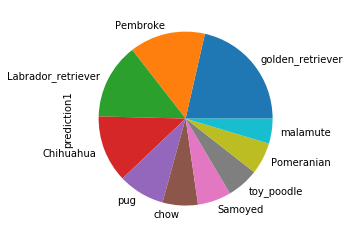

In [580]:
#Find most common dog's breeds
df.prediction1.value_counts()[:10].plot(kind='pie')

In [545]:
#Let's find how many dog's breeds are easy to predict
df.query('prediction1_dog==True & prediction2_dog==True & prediction3_dog==True').prediction1.nunique()

109

In [544]:
#Let's find how many dog's breeds are difficut to predict
df.query('prediction1_dog==True & prediction2_dog==False & prediction3_dog==False').prediction1.nunique()

21

Text(0.5, 1.0, "Top 15 dog's breeds with the highest average rating")

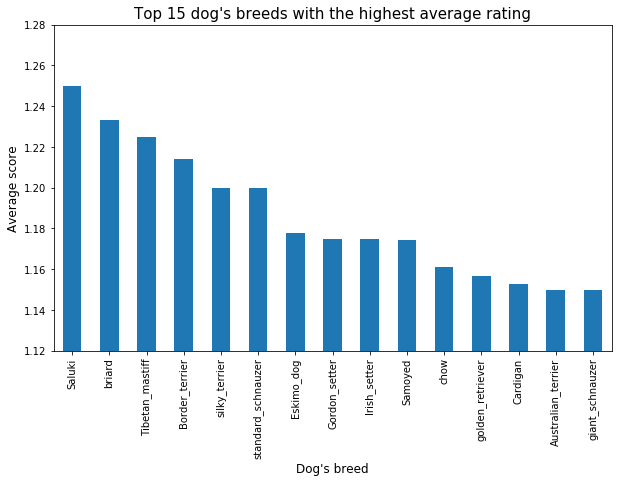

In [535]:
#Let's find top 15 dogs breeds based on average rating.

# Let's plot the top scores for the top 30 breeds on a standard bar chart
fig = plt.figure(figsize=(10,6))
df.groupby('prediction1').dog_rating.mean().sort_values(ascending=False)[:15].plot(kind='bar')
plt.ylim(1.12,1.28);
plt.xlabel("Dog's breed", fontsize=12)
plt.ylabel("Average score", fontsize=12)
plt.title("Top 15 dog's breeds with the highest average rating", fontsize=15)

Text(0.5, 1.0, "Top 15 dog's breeds with the highest favourite count")

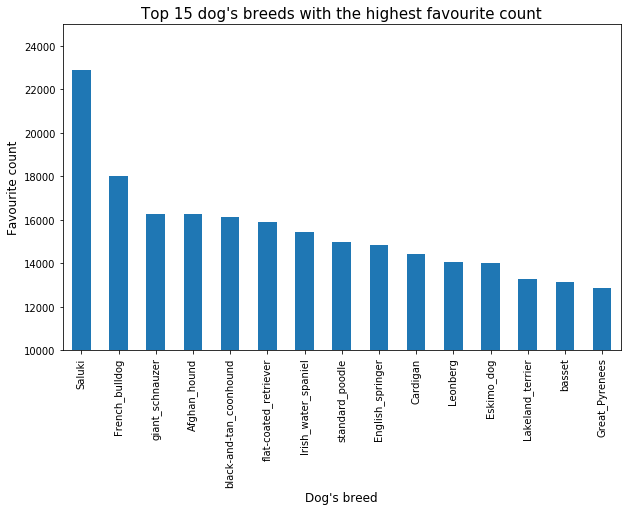

In [556]:
fig = plt.figure(figsize=(10,6))
df.groupby('prediction1').favorite_count.mean().sort_values(ascending=False)[:15].plot(kind='bar')
plt.ylim(10000,25000);
plt.xlabel("Dog's breed", fontsize=12)
plt.ylabel("Favourite count", fontsize=12)
plt.title("Top 15 dog's breeds with the highest favourite count", fontsize=15)

Text(0.5, 1.0, "Top 15 dog's breeds with the highest retweet count")

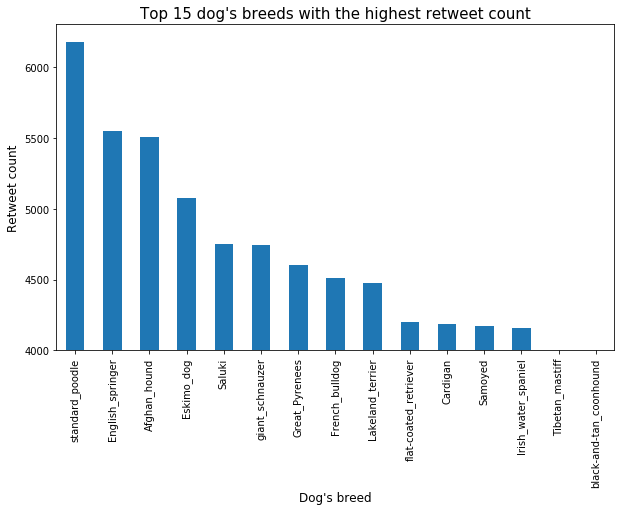

In [559]:
fig = plt.figure(figsize=(10,6))
df.groupby('prediction1').retweet_count.mean().sort_values(ascending=False)[:15].plot(kind='bar')
plt.ylim(4000,6300);
plt.xlabel("Dog's breed", fontsize=12)
plt.ylabel("Retweet count", fontsize=12)
plt.title("Top 15 dog's breeds with the highest retweet count", fontsize=15)

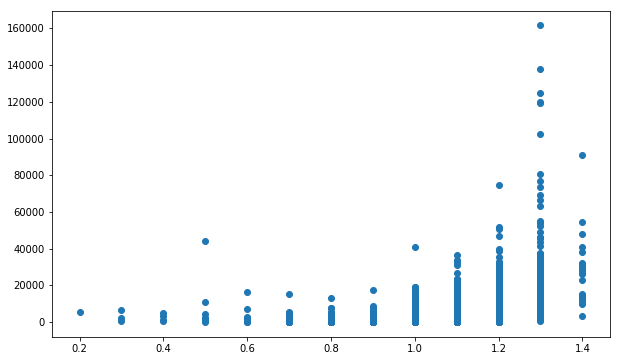

In [565]:
#Let's find relationship between dog's rating and favorite count
fig = plt.figure(figsize=(10,6))
pyplot.scatter(df.dog_rating, df.favorite_count)

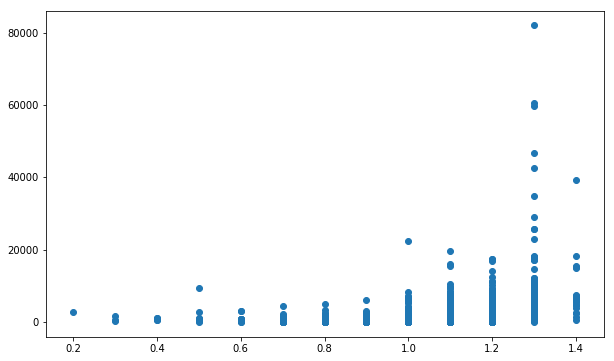

In [564]:
#Let's find relationship between dog's rating and retweet count
fig = plt.figure(figsize=(10,6))
pyplot.scatter(df.dog_rating, df.retweet_count)

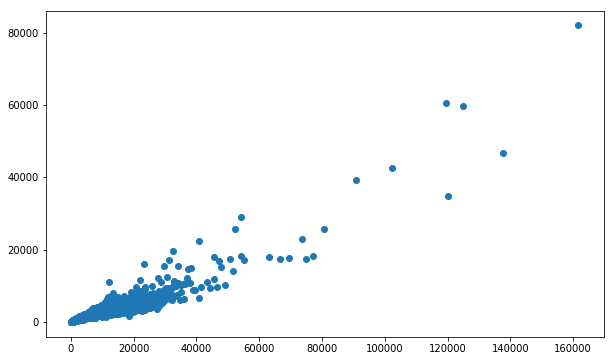

In [563]:
#Let's find correlation between favorite and retweet counts
fig = plt.figure(figsize=(10,6))
pyplot.scatter(df.favorite_count, df.retweet_count)


In [562]:
# Let's compute correlation coefficient
df['favorite_count'].corr(df['retweet_count'])

0.9280775345405421